# 1. Cài đặt Thư viện

In [1]:
#!pip install transformers==4.35.2 datasets torch numpy tqdm tensorboard torch==2.0.1

# 2 .Import các thư viện

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
from tqdm.notebook import tqdm
import numpy as np
import random
import pandas as pd
import copy
import math
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

# Thiết lập seed để reproducible
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-06-14 07:40:08.191423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749886808.396447      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749886808.452832      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


# 3. Load dataset

In [3]:
# Khởi tạo tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load datasets từ jsonl files
splits = {
    'train': 'train.jsonl',
    'validation': 'dev.jsonl',
    'test': 'test.jsonl'
}

try:
    # Cố gắng đọc từ Hugging Face Hub
    train_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["train"], lines=True)
    val_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["validation"], lines=True)
    test_df = pd.read_json("hf://datasets/SetFit/sst5/" + splits["test"], lines=True)
except Exception as e:
    print(f"Lỗi khi đọc từ HF Hub: {e}")
    print("Thử tải dataset bằng datasets library và chuyển sang DataFrame...")

    # Phương án backup: sử dụng datasets library và chuyển sang DataFrame
    from datasets import load_dataset
    dataset = load_dataset("SetFit/sst5")

    train_df = pd.DataFrame(dataset['train'])
    val_df = pd.DataFrame(dataset['validation'])
    test_df = pd.DataFrame(dataset['test'])

# Kiểm tra dữ liệu đã tải
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Hiển thị một vài mẫu dữ liệu
print("\nSample data examples:")
for i in range(5):
    text = train_df.iloc[i]['text']
    label = train_df.iloc[i]['label']
    sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
    print(f"\nText: {text}")
    print(f"Label: {label} ({sentiment_labels[label]})")

# Phân bố nhãn trong tập dữ liệu
print("\nLabel distribution:")
train_distribution = train_df['label'].value_counts().sort_index()
val_distribution = val_df['label'].value_counts().sort_index()
test_distribution = test_df['label'].value_counts().sort_index()

print("Training set:")
for label, count in train_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

print("\nValidation set:")
for label, count in val_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

print("\nTest set:")
for label, count in test_distribution.items():
    print(f"  Label {label} ({sentiment_labels[label]}): {count} samples")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training samples: 8544
Validation samples: 1101
Test samples: 2210

Sample data examples:

Text: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Label: 4 (very positive)

Text: apparently reassembled from the cutting-room floor of any given daytime soap .
Label: 1 (negative)

Text: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
Label: 1 (negative)

Text: the entire movie is filled with deja vu moments .
Label: 2 (neutral)

Text: this is a visually stunning rumination on love , memory , history and the war between art and commerce .
Label: 3 (positive)

Label distribution:
Training set:
  Label 0 (very negative): 1092 samples
  Label 1 (negative): 2218 samples
  Label 2 (neutral): 1624 samples
  Label 3 (positive): 2322 samples
  Label 4 (very positive): 1

# 4. Tạo Custom Dataset cho SST-5

In [4]:
# 4. Tạo Custom Dataset cho SST-5

class SST5Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SST5Dataset(train_df, tokenizer)
val_dataset = SST5Dataset(val_df, tokenizer)
test_dataset = SST5Dataset(test_df, tokenizer)

# Create dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Kiểm tra một batch
sample_batch = next(iter(train_dataloader))
print("\nSample batch shape:")
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")


Sample batch shape:
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Labels shape: torch.Size([32])


# 5. Định nghĩa model

In [5]:
# 5. Định nghĩa model cho PPO và DPO

class PPOModel(nn.Module):
    def __init__(self, num_labels=5):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.policy_head = nn.Linear(768, num_labels)
        self.value_head = nn.Linear(768, 1)
        
    def forward(self, input_ids, attention_mask, return_value=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden = outputs.last_hidden_state[:, 0, :]
        logits = self.policy_head(hidden)
        
        if return_value:
            values = self.value_head(hidden).squeeze(-1)
            return logits, values
        return logits

class DPOModel(nn.Module):
    def __init__(self, num_labels=5):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=num_labels
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        if labels is not None:
            return outputs
        return outputs.logits


# 6. PPO Training

In [6]:
# 6. PPO Training với cải tiến và kiểm soát loss

class PPOTrainer:
    def __init__(self, model, optimizer, clip_ratio=0.2, entropy_coef=0.01, value_coef=0.1, max_grad_norm=0.5):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef  # Giảm từ 0.5 xuống 0.1
        self.max_grad_norm = max_grad_norm

    def compute_gae(self, rewards, values, masks, next_value, gamma=0.99, lambda_=0.95):
        """Computes Generalized Advantage Estimation (GAE)"""
        gae = 0
        advantages = []
        
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + gamma * next_value * masks[i] - values[i]
            gae = delta + gamma * lambda_ * masks[i] * gae
            advantages.insert(0, gae)
            next_value = values[i]
            
        return torch.tensor(advantages, dtype=torch.float, device=device)

    def compute_ppo_loss(self, old_logits, new_logits, old_values, new_values, advantages, returns, actions, epoch=0):
        # Convert logits to probabilities
        old_probs = F.softmax(old_logits, dim=-1)
        new_probs = F.softmax(new_logits, dim=-1)
    
        # Get probabilities for taken actions
        old_action_probs = old_probs.gather(1, actions.unsqueeze(1)).squeeze()
        new_action_probs = new_probs.gather(1, actions.unsqueeze(1)).squeeze()
    
        # Calculate ratio
        ratio = new_action_probs / (old_action_probs + 1e-8)
    
        # Calculate surrogate losses
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
        
        # Calculate entropy bonus (encourage exploration)
        entropy = -(new_probs * torch.log(new_probs + 1e-8)).sum(dim=-1).mean()
    
        # PPO actor loss (negative because we want to maximize reward)
        actor_loss = -torch.min(surr1, surr2).mean()
        
        # PPO critic loss (value function)
        value_pred_clipped = old_values + torch.clamp(
            new_values - old_values, -self.clip_ratio, self.clip_ratio
        )
        value_loss1 = F.mse_loss(new_values, returns)
        value_loss2 = F.mse_loss(value_pred_clipped, returns)
        value_loss = torch.max(value_loss1, value_loss2)
        
        # Thêm CrossEntropy auxiliary loss
        ce_loss = F.cross_entropy(new_logits, actions)
        
        # Kết hợp losses với trọng số động theo epoch
        ce_weight = min(0.6, 0.4 + epoch * 0.05)  # Tăng dần CE weight theo epoch
        ppo_weight = 1.0 - ce_weight
        
        # Normalize các thành phần loss để kiểm soát magnitude
        normalized_actor_loss = actor_loss / (torch.abs(actor_loss).detach() + 1.0)
        normalized_value_loss = value_loss / (torch.abs(value_loss).detach() + 1.0)
        
        # Tổng hợp loss cuối cùng với normalization
        total_loss = (ppo_weight * normalized_actor_loss + 
                      ce_weight * ce_loss + 
                      self.value_coef * normalized_value_loss - 
                      self.entropy_coef * entropy)
        
        return total_loss, actor_loss.item(), value_loss.item(), entropy.item()

def train_ppo(model, train_loader, val_loader, num_epochs=10):
    # Sử dụng learning rate nhỏ hơn và weight_decay lớn hơn
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=1, threshold=0.01, min_lr=5e-6, verbose=True
    )
    
    trainer = PPOTrainer(model, optimizer, max_grad_norm=0.5)
    writer = SummaryWriter(f'runs/ppo_sst5_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    
    # For early stopping
    best_val_distance = float('inf')
    best_model_state = None
    patience = 3
    no_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_actor_loss = 0
        total_value_loss = 0
        total_entropy = 0
        correct = 0
        total = 0
        
        # Distance metrics for 5-class classification
        total_distance = 0  # Sum of absolute distance between predicted and true labels

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"PPO Epoch {epoch+1}")):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Get old predictions with values
            with torch.no_grad():
                old_logits, old_values = model(batch['input_ids'], batch['attention_mask'], return_value=True)

            # Get new predictions with values
            new_logits, new_values = model(batch['input_ids'], batch['attention_mask'], return_value=True)

            # Calculate rewards based on distance from true label
            predictions = torch.argmax(new_logits, dim=1)
            rewards = torch.ones_like(predictions, dtype=torch.float)
            masks = torch.ones_like(predictions, dtype=torch.float)  # No terminal states in our case
            
            # Calculate reward based on distance from true label
            for i in range(len(predictions)):
                pred = predictions[i].item()
                true = batch['labels'][i].item()
                distance = abs(pred - true)
                
                # Update distance metric
                total_distance += distance
                
                # Improved reward function
                if distance == 0:
                    rewards[i] = 2.0
                elif distance == 1:
                    rewards[i] = 0.8  # Less punishment for being close
                else:
                    rewards[i] = max(0, 0.4 * math.exp(-0.8 * (distance - 1)))  # Exponential decay
            
            # Normalize rewards để kiểm soát magnitude
            if rewards.std() > 0:
                rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
                
            # Calculate returns and advantages
            next_value = 0  # Terminal value at end of sequence
            advantages = trainer.compute_gae(
                rewards.cpu().numpy().tolist(),
                old_values.detach().cpu().numpy().tolist(),
                masks.cpu().numpy().tolist(),
                next_value
            )
            returns = advantages + old_values.detach()
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Calculate PPO loss
            loss, actor_loss, value_loss, entropy = trainer.compute_ppo_loss(
                old_logits,
                new_logits,
                old_values,
                new_values,
                advantages,
                returns,
                batch['labels']
            )

            # Kiểm tra loss bất thường và áp dụng cắt/scale nếu cần
            if torch.isnan(loss) or torch.isinf(loss) or abs(loss.item()) > 10.0:
                print(f"Warning: Unusual loss value detected: {loss.item()} at batch {batch_idx}")
                if not torch.isnan(loss) and not torch.isinf(loss):
                    # Scale down loss nếu quá lớn
                    loss = loss * 10.0 / abs(loss.item())
                else:
                    # Skip batch nếu loss là NaN hoặc Inf
                    print("Skipping this batch due to invalid loss")
                    continue

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=trainer.max_grad_norm)
            
            optimizer.step()

            total_loss += loss.item()
            total_actor_loss += actor_loss
            total_value_loss += value_loss
            total_entropy += entropy
            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_distance = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(batch['input_ids'], batch['attention_mask'])
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)
                
                # Calculate distance metric for validation
                for i in range(len(predictions)):
                    val_distance += abs(predictions[i].item() - batch['labels'][i].item())

        train_accuracy = correct / total if total > 0 else 0
        train_avg_distance = total_distance / total if total > 0 else 0
        val_accuracy = val_correct / val_total if val_total > 0 else 0
        val_avg_distance = val_distance / val_total if val_total > 0 else 0

        # Update learning rate scheduler
        scheduler.step(val_avg_distance)

        print(f'PPO Epoch {epoch+1}:')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Actor Loss: {total_actor_loss/len(train_loader):.4f}')
        print(f'Value Loss: {total_value_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}')
        print(f'Training Avg Distance: {train_avg_distance:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Avg Distance: {val_avg_distance:.4f}')

        # Log chi tiết các thành phần loss
        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        writer.add_scalar('Actor Loss/train', total_actor_loss/len(train_loader), epoch)
        writer.add_scalar('Value Loss/train', total_value_loss/len(train_loader), epoch)
        writer.add_scalar('Entropy/train', total_entropy/len(train_loader), epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Avg Distance/train', train_avg_distance, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Avg Distance/val', val_avg_distance, epoch)
        
        # Check for improvement and early stopping
        if val_avg_distance < best_val_distance:
            best_val_distance = val_avg_distance
            best_model_state = copy.deepcopy(model.state_dict())
            no_improvement = 0
        else:
            no_improvement += 1
        
        # Early stopping check
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation avg distance: {best_val_distance:.4f}")
            model.load_state_dict(best_model_state)
            break

    # If we went through all epochs, load the best model
    if best_model_state is not None and no_improvement < patience:
        model.load_state_dict(best_model_state)
        print(f"Training completed. Loading best model with validation avg distance: {best_val_distance:.4f}")

    return model

# 7 . DPO Training

In [7]:
# 7. DPO Training với KL Regularization rõ ràng hơn

class DPOTrainer:
    def __init__(self, policy_model, ref_model, optimizer, beta=0.1, kl_coef=0.03):
        self.policy_model = policy_model.to(device)
        self.ref_model = ref_model.to(device)
        self.optimizer = optimizer
        self.beta = beta
        self.kl_coef = kl_coef
        
    def create_preference_pairs(self, inputs, labels):
        """
        Create preferred and rejected outputs based on distance to true labels
        For each input, we'll create a pair where:
        - preferred output is closer to the true label
        - rejected output is further from the true label
        """
        batch_size = labels.size(0)
        preferred_labels = torch.zeros_like(labels)
        rejected_labels = torch.zeros_like(labels)
        
        for i in range(batch_size):
            true_label = labels[i].item()
            
            # Cải thiện cách chọn preferred/rejected label
            if true_label == 0:
                preferred_label = 1
                rejected_label = 4
            elif true_label == 1:
                preferred_label = 0 if random.random() < 0.5 else 2
                rejected_label = 4
            elif true_label == 2:
                preferred_label = 1 if random.random() < 0.5 else 3
                rejected_label = 4 if random.random() < 0.5 else 0
            elif true_label == 3:
                preferred_label = 2 if random.random() < 0.5 else 4
                rejected_label = 0
            else:  # true_label == 4
                preferred_label = 3
                rejected_label = 0
            
            preferred_labels[i] = preferred_label
            rejected_labels[i] = rejected_label
            
        return preferred_labels, rejected_labels
    
    def compute_dpo_loss(self, input_ids, attention_mask, chosen_labels, rejected_labels, epoch=0):
        # Get log probabilities from policy model
        with torch.set_grad_enabled(True):
            policy_outputs_chosen = self.policy_model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                labels=chosen_labels
            )
            policy_outputs_rejected = self.policy_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=rejected_labels
            )
        
        # Get log probabilities from reference model (frozen)
        with torch.no_grad():
            ref_outputs_chosen = self.ref_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=chosen_labels
            )
            ref_outputs_rejected = self.ref_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=rejected_labels
            )
        
        # Extract logits
        policy_chosen_logits = policy_outputs_chosen.logits
        policy_rejected_logits = policy_outputs_rejected.logits
        ref_chosen_logits = ref_outputs_chosen.logits
        ref_rejected_logits = ref_outputs_rejected.logits
        
        # Get log probs for chosen and rejected labels
        policy_chosen_log_probs = F.log_softmax(policy_chosen_logits, dim=-1).gather(
            1, chosen_labels.unsqueeze(-1)
        ).squeeze(-1)
        policy_rejected_log_probs = F.log_softmax(policy_rejected_logits, dim=-1).gather(
            1, rejected_labels.unsqueeze(-1)
        ).squeeze(-1)
        
        ref_chosen_log_probs = F.log_softmax(ref_chosen_logits, dim=-1).gather(
            1, chosen_labels.unsqueeze(-1)
        ).squeeze(-1)
        ref_rejected_log_probs = F.log_softmax(ref_rejected_logits, dim=-1).gather(
            1, rejected_labels.unsqueeze(-1)
        ).squeeze(-1)
        
        # Calculate the log ratios (π_θ/π_ref)
        chosen_rewards = policy_chosen_log_probs - ref_chosen_log_probs.detach()
        rejected_rewards = policy_rejected_log_probs - ref_rejected_log_probs.detach()
        
        # Explicit KL divergence calculation
        kl_chosen = F.kl_div(
            F.log_softmax(policy_chosen_logits, dim=-1),
            F.softmax(ref_chosen_logits, dim=-1),
            reduction='batchmean'
        )
        
        kl_rejected = F.kl_div(
            F.log_softmax(policy_rejected_logits, dim=-1),
            F.softmax(ref_rejected_logits, dim=-1),
            reduction='batchmean'
        )
        
        # Calculate loss using the DPO loss formula - với beta tăng nhẹ theo epoch
        effective_beta = self.beta * (1 + epoch * 0.05)  # Tăng dần từ 0.1 đến 0.125
        dpo_loss = -torch.log(torch.sigmoid(effective_beta * (chosen_rewards - rejected_rewards)))
        
        # Add KL regularization
        kl_penalty = (kl_chosen + kl_rejected) / 2
        
        # Thêm CE loss với trọng số nhỏ
        ce_loss = F.cross_entropy(policy_chosen_logits, chosen_labels)
        ce_weight = 0.1
        
        # Total loss
        loss = dpo_loss.mean() + self.kl_coef * kl_penalty + ce_weight * ce_loss
        
        return loss, dpo_loss.mean().item(), kl_penalty.item()

def train_dpo(policy_model, train_loader, val_loader, num_epochs=5):
    # Create a copy of the policy model to serve as reference
    ref_model = copy.deepcopy(policy_model)
    
    # Freeze the reference model
    for param in ref_model.parameters():
        param.requires_grad = False
    
    # Giảm learning rate để tránh overshooting
    optimizer = optim.AdamW(policy_model.parameters(), lr=7e-6, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
    trainer = DPOTrainer(policy_model, ref_model, optimizer)
    writer = SummaryWriter(f'runs/dpo_sst5_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    
    # For early stopping - kết hợp cả accuracy và distance
    best_combined_metric = float('inf')
    best_model_state = None
    patience = 3
    no_improvement = 0

    for epoch in range(num_epochs):
        # Warm-up phase ở epoch đầu tiên
        if epoch == 0:
            for g in optimizer.param_groups:
                g['lr'] = g['lr'] * 0.5  # Bắt đầu với 50% learning rate
                
        policy_model.train()
        total_loss = 0
        total_dpo_loss = 0
        total_kl = 0
        
        for batch in tqdm(train_loader, desc=f"DPO Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Create preference pairs
            chosen_labels, rejected_labels = trainer.create_preference_pairs(
                batch['input_ids'], batch['labels']
            )
            
            # Calculate DPO loss
            loss, dpo_loss, kl_penalty = trainer.compute_dpo_loss(
                batch['input_ids'],
                batch['attention_mask'],
                chosen_labels,
                rejected_labels,
                epoch  # Truyền epoch vào compute_dpo_loss
            )
            
            # Check for unusual loss
            if torch.isnan(loss) or torch.isinf(loss) or abs(loss.item()) > 100:
                print(f"Warning: Unusual DPO loss value detected: {loss.item()}")
                continue
            
            # Optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=0.5)
            
            optimizer.step()
            
            total_loss += loss.item()
            total_dpo_loss += dpo_loss
            total_kl += kl_penalty

        # Validation
        policy_model.eval()
        val_correct = 0
        val_total = 0
        val_distance = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = policy_model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)
                
                # Calculate distance metric for validation
                for i in range(len(predictions)):
                    val_distance += abs(predictions[i].item() - batch['labels'][i].item())

        val_accuracy = val_correct / val_total
        val_avg_distance = val_distance / val_total

        # Update scheduler
        scheduler.step(val_avg_distance)

        print(f'DPO Epoch {epoch+1}:')
        print(f'DPO Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'DPO Loss: {total_dpo_loss/len(train_loader):.4f}')
        print(f'KL Penalty: {total_kl/len(train_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Avg Distance: {val_avg_distance:.4f}')

        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        writer.add_scalar('DPO Loss/train', total_dpo_loss/len(train_loader), epoch)
        writer.add_scalar('KL Penalty/train', total_kl/len(train_loader), epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Avg Distance/val', val_avg_distance, epoch)
        
        # Cải thiện early stopping dựa trên combined metric
        combined_metric = val_avg_distance - 0.05 * val_accuracy
        if combined_metric < best_combined_metric:
            best_combined_metric = combined_metric
            best_val_distance = val_avg_distance  # Vẫn lưu để báo cáo
            best_model_state = copy.deepcopy(policy_model.state_dict())
            no_improvement = 0
        else:
            no_improvement += 1
        
        # Early stopping check
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation avg distance: {best_val_distance:.4f}")
            policy_model.load_state_dict(best_model_state)
            break
    
    # If we went through all epochs, load the best model
    if best_model_state is not None and no_improvement < patience:
        policy_model.load_state_dict(best_model_state)
        print(f"Training completed. Loading best model with validation avg distance: {best_val_distance:.4f}")

    return policy_model

# 8.  Khởi hành training

In [8]:
# 8. Khởi hành training

# Initialize models
ppo_model = PPOModel(num_labels=5).to(device)
dpo_model = DPOModel(num_labels=5).to(device)

# Train PPO
print("Training PPO model...")
trained_ppo = train_ppo(ppo_model, train_dataloader, val_dataloader, num_epochs=10)

# Train DPO
print("\nTraining DPO model...")
trained_dpo = train_dpo(dpo_model, train_dataloader, val_dataloader, num_epochs=10)

# Save models
torch.save(trained_ppo.state_dict(), 'ppo_sst5.pth')
torch.save(trained_dpo.state_dict(), 'dpo_sst5.pth')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PPO model...


PPO Epoch 1:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 1:
Training Loss: 0.6728
Actor Loss: 0.0191
Value Loss: 3.3961
Training Accuracy: 0.3536
Training Avg Distance: 0.9663
Validation Accuracy: 0.4214
Validation Avg Distance: 0.7157


PPO Epoch 2:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 2:
Training Loss: 0.6168
Actor Loss: 0.0448
Value Loss: 3.2989
Training Accuracy: 0.4604
Training Avg Distance: 0.6522
Validation Accuracy: 0.4478
Validation Avg Distance: 0.6540


PPO Epoch 3:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 3:
Training Loss: 0.5980
Actor Loss: 0.0441
Value Loss: 3.2880
Training Accuracy: 0.4879
Training Avg Distance: 0.6119
Validation Accuracy: 0.4814
Validation Avg Distance: 0.6312


PPO Epoch 4:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 4:
Training Loss: 0.5837
Actor Loss: 0.0614
Value Loss: 3.2292
Training Accuracy: 0.5323
Training Avg Distance: 0.5557
Validation Accuracy: 0.4759
Validation Avg Distance: 0.6322


PPO Epoch 5:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 5:
Training Loss: 0.5822
Actor Loss: 0.0651
Value Loss: 3.3330
Training Accuracy: 0.5536
Training Avg Distance: 0.5235
Validation Accuracy: 0.4850
Validation Avg Distance: 0.6231


PPO Epoch 6:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 6:
Training Loss: 0.5850
Actor Loss: 0.0737
Value Loss: 3.2000
Training Accuracy: 0.5761
Training Avg Distance: 0.5042
Validation Accuracy: 0.4877
Validation Avg Distance: 0.6131


PPO Epoch 7:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 7:
Training Loss: 0.5691
Actor Loss: 0.0769
Value Loss: 3.1715
Training Accuracy: 0.5974
Training Avg Distance: 0.4786
Validation Accuracy: 0.4777
Validation Avg Distance: 0.6013


PPO Epoch 8:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 8:
Training Loss: 0.5857
Actor Loss: 0.0973
Value Loss: 3.2712
Training Accuracy: 0.6197
Training Avg Distance: 0.4559
Validation Accuracy: 0.5014
Validation Avg Distance: 0.5758


PPO Epoch 9:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 9:
Training Loss: 0.5824
Actor Loss: 0.0867
Value Loss: 3.1851
Training Accuracy: 0.6388
Training Avg Distance: 0.4340
Validation Accuracy: 0.5014
Validation Avg Distance: 0.5722


PPO Epoch 10:   0%|          | 0/267 [00:00<?, ?it/s]

PPO Epoch 10:
Training Loss: 0.5810
Actor Loss: 0.1438
Value Loss: 3.2956
Training Accuracy: 0.6579
Training Avg Distance: 0.4168
Validation Accuracy: 0.4941
Validation Avg Distance: 0.6049
Training completed. Loading best model with validation avg distance: 0.5722

Training DPO model...


DPO Epoch 1:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 1:
DPO Training Loss: 0.8047
DPO Loss: 0.6349
KL Penalty: 0.2618
Validation Accuracy: 0.3778
Validation Avg Distance: 0.7511


DPO Epoch 2:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 2:
DPO Training Loss: 0.7275
DPO Loss: 0.5588
KL Penalty: 0.5827
Validation Accuracy: 0.4487
Validation Avg Distance: 0.6367


DPO Epoch 3:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 3:
DPO Training Loss: 0.6655
DPO Loss: 0.4881
KL Penalty: 0.9376
Validation Accuracy: 0.4487
Validation Avg Distance: 0.6294


DPO Epoch 4:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 4:
DPO Training Loss: 0.6150
DPO Loss: 0.4313
KL Penalty: 1.2204
Validation Accuracy: 0.4550
Validation Avg Distance: 0.6258


DPO Epoch 5:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 5:
DPO Training Loss: 0.5725
DPO Loss: 0.3817
KL Penalty: 1.4641
Validation Accuracy: 0.4596
Validation Avg Distance: 0.6176


DPO Epoch 6:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 6:
DPO Training Loss: 0.5361
DPO Loss: 0.3386
KL Penalty: 1.6922
Validation Accuracy: 0.4596
Validation Avg Distance: 0.6213


DPO Epoch 7:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 7:
DPO Training Loss: 0.4984
DPO Loss: 0.2985
KL Penalty: 1.8921
Validation Accuracy: 0.4559
Validation Avg Distance: 0.6294


DPO Epoch 8:   0%|          | 0/267 [00:00<?, ?it/s]

DPO Epoch 8:
DPO Training Loss: 0.4730
DPO Loss: 0.2701
KL Penalty: 2.0252
Validation Accuracy: 0.4541
Validation Avg Distance: 0.6340
Early stopping at epoch 8 with best validation avg distance: 0.6176


# 9. Testing Models

In [9]:
# 9. Model Testing và Đánh giá

def predict_sentiment(model, text):
    model.eval()
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        if hasattr(model, 'forward') and callable(getattr(model, 'forward')):
            outputs = model(inputs['input_ids'], inputs['attention_mask'])
        else:
            outputs = model(**inputs)
        prediction = torch.argmax(outputs, dim=1).item()

    sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
    return prediction, sentiment_labels[prediction]

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_distance = 0
    confusion_matrix = torch.zeros(5, 5, dtype=torch.long)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

            # Update confusion matrix
            for i in range(len(predictions)):
                confusion_matrix[batch['labels'][i], predictions[i]] += 1
                total_distance += abs(predictions[i].item() - batch['labels'][i].item())

    accuracy = correct / total
    avg_distance = total_distance / total

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average Distance: {avg_distance:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix)

    return accuracy, avg_distance, confusion_matrix

# Test examples
test_sentences = [
    "this movie was absolutely fantastic.",
    "i really didn't enjoy this thriller at all.",
    "the acting was decent but the plot was confusing.",
    "it was watchable, nothing special really.",
    "this is the best film I've seen all year."
]

print("PPO Model Predictions:")
for sentence in test_sentences:
    label_idx, sentiment = predict_sentiment(trained_ppo, sentence)
    print(f"\nSentence: {sentence}")
    print(f"Prediction: {label_idx} ({sentiment})")

print("\nDPO Model Predictions:")
for sentence in test_sentences:
    label_idx, sentiment = predict_sentiment(trained_dpo, sentence)
    print(f"\nSentence: {sentence}")
    print(f"Prediction: {label_idx} ({sentiment})")

# Evaluate on test set
print("\nEvaluating PPO model on test set:")
ppo_accuracy, ppo_distance, ppo_confusion = evaluate_model(trained_ppo, test_dataloader)

print("\nEvaluating DPO model on test set:")
dpo_accuracy, dpo_distance, dpo_confusion = evaluate_model(trained_dpo, test_dataloader)

# Compare performance
print("\nPerformance Comparison:")
print(f"PPO Accuracy: {ppo_accuracy:.4f}, Average Distance: {ppo_distance:.4f}")
print(f"DPO Accuracy: {dpo_accuracy:.4f}, Average Distance: {dpo_distance:.4f}")

PPO Model Predictions:

Sentence: this movie was absolutely fantastic.
Prediction: 4 (very positive)

Sentence: i really didn't enjoy this thriller at all.
Prediction: 1 (negative)

Sentence: the acting was decent but the plot was confusing.
Prediction: 1 (negative)

Sentence: it was watchable, nothing special really.
Prediction: 3 (positive)

Sentence: this is the best film I've seen all year.
Prediction: 4 (very positive)

DPO Model Predictions:

Sentence: this movie was absolutely fantastic.
Prediction: 3 (positive)

Sentence: i really didn't enjoy this thriller at all.
Prediction: 1 (negative)

Sentence: the acting was decent but the plot was confusing.
Prediction: 1 (negative)

Sentence: it was watchable, nothing special really.
Prediction: 1 (negative)

Sentence: this is the best film I've seen all year.
Prediction: 3 (positive)

Evaluating PPO model on test set:


Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.5077
Average Distance: 0.5683
Confusion Matrix:
tensor([[ 73, 187,  17,   2,   0],
        [ 49, 458,  92,  31,   3],
        [  6, 171, 117,  84,  11],
        [  2,  42,  76, 310,  80],
        [  1,  10,  24, 200, 164]])

Evaluating DPO model on test set:


Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.4475
Average Distance: 0.6317
Confusion Matrix:
tensor([[  0, 260,  14,   5,   0],
        [  0, 545,  42,  46,   0],
        [  0, 229,  40, 116,   4],
        [  0,  62,  36, 402,  10],
        [  0,  12,  15, 370,   2]])

Performance Comparison:
PPO Accuracy: 0.5077, Average Distance: 0.5683
DPO Accuracy: 0.4475, Average Distance: 0.6317


# 10. Phân tích kết quả

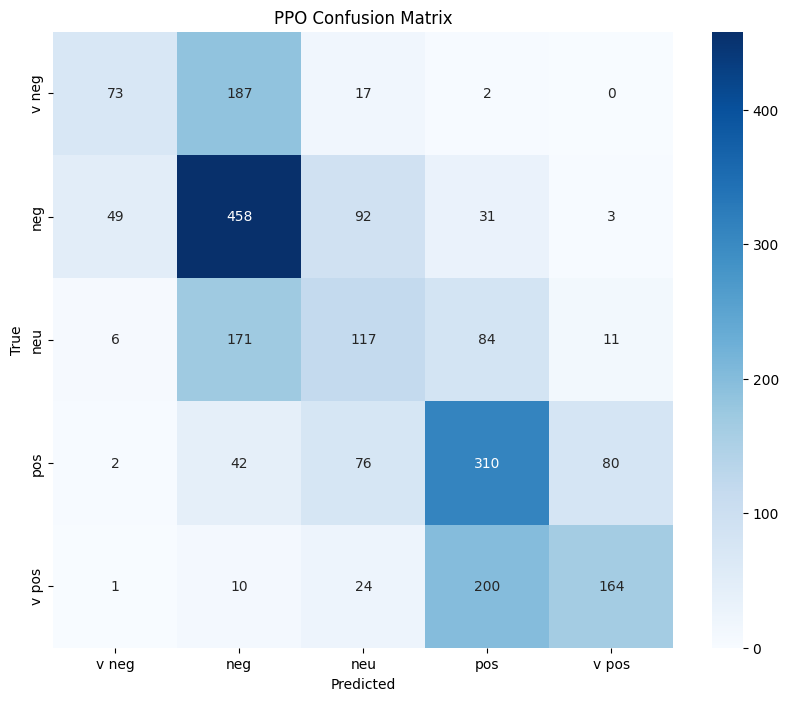

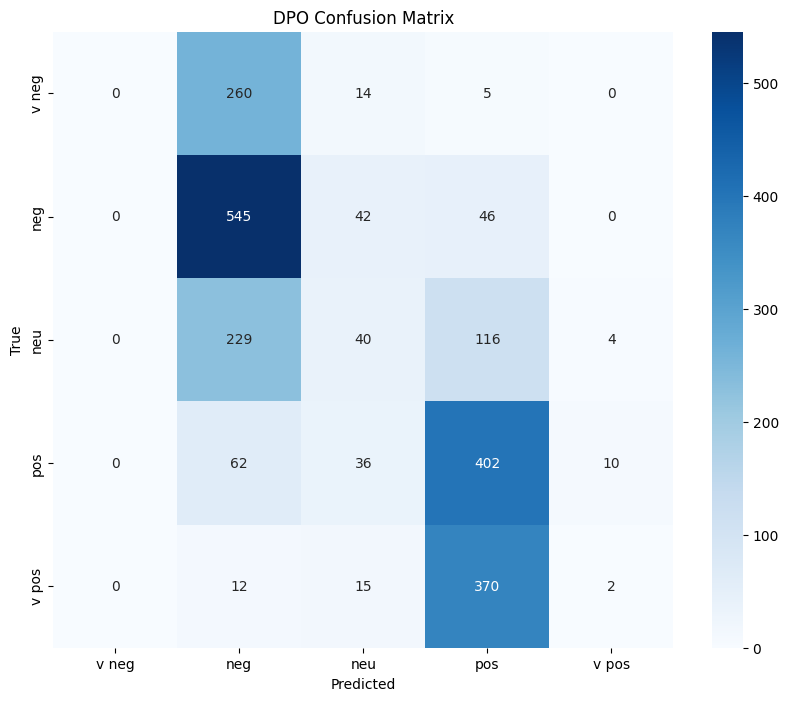


PPO Model Metrics per Class:
very negative: Precision=0.5573, Recall=0.2616, F1=0.3561
negative: Precision=0.5276, Recall=0.7235, F1=0.6103
neutral: Precision=0.3589, Recall=0.3008, F1=0.3273
positive: Precision=0.4944, Recall=0.6078, F1=0.5453
very positive: Precision=0.6357, Recall=0.4110, F1=0.4992

DPO Model Metrics per Class:
very negative: Precision=0.0000, Recall=0.0000, F1=0.0000
negative: Precision=0.4919, Recall=0.8610, F1=0.6261
neutral: Precision=0.2721, Recall=0.1028, F1=0.1493
positive: Precision=0.4281, Recall=0.7882, F1=0.5549
very positive: Precision=0.1250, Recall=0.0050, F1=0.0096


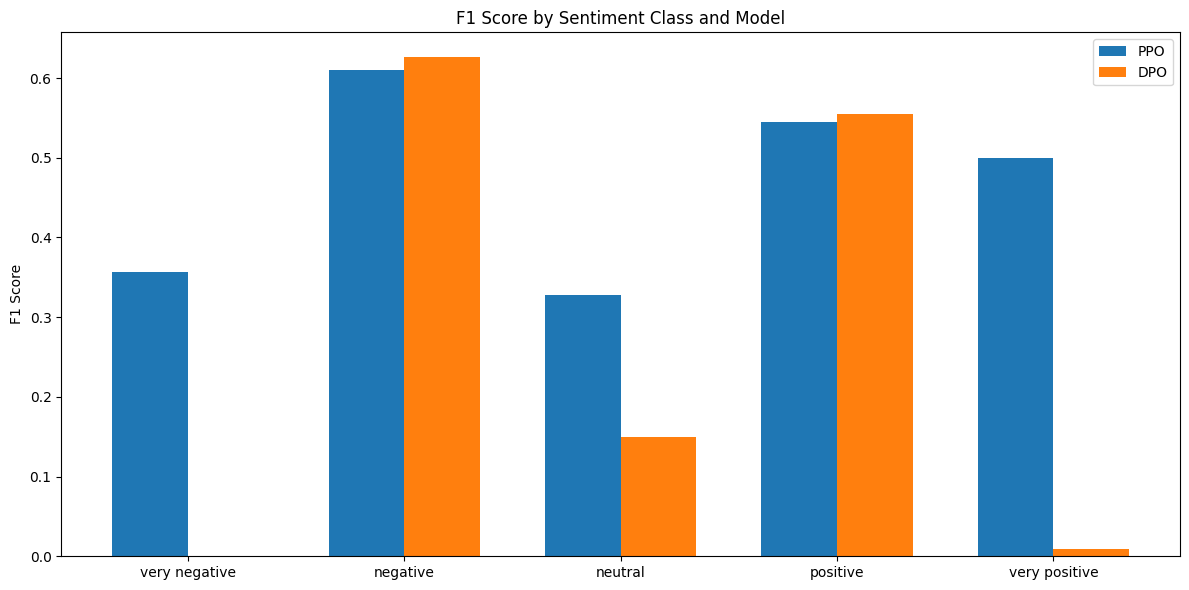

In [10]:
# 10. Phân tích kết quả chi tiết

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["v neg", "neg", "neu", "pos", "v pos"],
                yticklabels=["v neg", "neg", "neu", "pos", "v pos"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(ppo_confusion.cpu().numpy(), 'PPO Confusion Matrix')
plot_confusion_matrix(dpo_confusion.cpu().numpy(), 'DPO Confusion Matrix')

# Calculate per-class metrics
def get_metrics_per_class(confusion):
    cm = confusion.cpu().numpy()
    precision = np.zeros(5)
    recall = np.zeros(5)
    f1 = np.zeros(5)

    for i in range(5):
        # Precision: TP / (TP + FP)
        precision[i] = cm[i, i] / (cm[:, i].sum() + 1e-10)

        # Recall: TP / (TP + FN)
        recall[i] = cm[i, i] / (cm[i, :].sum() + 1e-10)

        # F1: 2 * (precision * recall) / (precision + recall)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)

    return precision, recall, f1

ppo_precision, ppo_recall, ppo_f1 = get_metrics_per_class(ppo_confusion)
dpo_precision, dpo_recall, dpo_f1 = get_metrics_per_class(dpo_confusion)

# Print metrics per class
sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
print("\nPPO Model Metrics per Class:")
for i in range(5):
    print(f"{sentiment_labels[i]}: Precision={ppo_precision[i]:.4f}, Recall={ppo_recall[i]:.4f}, F1={ppo_f1[i]:.4f}")

print("\nDPO Model Metrics per Class:")
for i in range(5):
    print(f"{sentiment_labels[i]}: Precision={dpo_precision[i]:.4f}, Recall={dpo_recall[i]:.4f}, F1={dpo_f1[i]:.4f}")

# Plot comparison of F1 scores
labels = sentiment_labels
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ppo_f1, width, label='PPO')
rects2 = ax.bar(x + width/2, dpo_f1, width, label='DPO')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Sentiment Class and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()